# Import and Check OS

In [1]:
import sys


import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import scipy.ndimage as nd

In [2]:
def change_contrast_brightness(image, alpha, beta):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
    return new_image

def gamma_adjustment(img_original, gamma):
    """
    https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html
    """
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv2.LUT(img_original, lookUpTable)
    return res

In [3]:
if 'win32' in sys.platform:
    ex_filepath = 'F:\Colonies_Data\data\plate 2_24.png'
if 'darwin' in sys.platform:
    ex_filepath = "/Volumes/Samsung_T5/Colonies_Data/data/plate 2_24.png"

# Find the plate

## Find position and radius of the plate

In [8]:
# https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
ex_filepath = "/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12.JPG"
IMG_SIZE = 1000

image = cv2.imread(ex_filepath)
image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
output = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=int(IMG_SIZE/3), dp=2, minRadius=int(IMG_SIZE/3), maxRadius=int(IMG_SIZE/2))
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    x, y, r = circle_[0]


[[525 461 470]]


## Extract the plate

In [28]:
img = Image.open(ex_filepath).convert("RGB").resize((1000,1000))

npImage=np.array(img)
image = change_contrast_brightness(npImage, .8, 10)

# Create same size alpha layer with circle
alpha = Image.new('L', img.size,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([x-r, y-r, x+r, y+r],0,360,fill=255)

# Convert alpha Image to numpy array
npAlpha=np.array(alpha)

# Add alpha layer to RGB
npImage=np.dstack((image,npAlpha))

# Save with alpha
Image.fromarray(npImage).save('result.png')

# Find Small circles

In [7]:
image = cv2.imread('result.png', cv2.IMREAD_UNCHANGED)
image2 = cv2.bitwise_not(image[:,:,:3])
output = image2.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, minDist=1, dp=2, minRadius=10, maxRadius=25, param2=37)
 
    
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circle_ = np.round(circles[0, :]).astype("int")
    print(circle_)
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circle_:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
    # show the output image
#     cv2.imshow("output", np.hstack([image2, output]))
#     cv2.waitKey(0)

[[705 933  24]
 [703 935  24]
 [699 937  24]
 ...
 [199 771  11]
 [671 941  11]
 [413 971  11]]


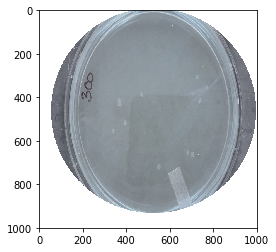

In [9]:
def window_stdev(arr, radius):
    c1 = nd.filters.uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = nd.filters.uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1,:-radius*2+1]

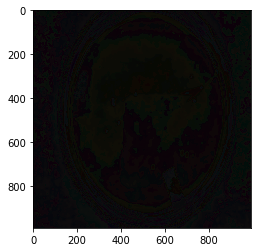

In [17]:
plt.imshow(window_stdev(image[:,:,:3], 5).astype(int))

## Attempting Template Matching

In [11]:
img = cv2.imread(ex_filepath,0)
img2 = img.copy()
template = cv2.imread("/Volumes/Samsung_T5/Segmentation_Data/VC0395_300mOsm_12_colony.JPG",0)
img_rgb = cv2.imread(ex_filepath)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.6
loc = np.where( res >= threshold)
print(loc)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

cv2.imwrite('res.png',img_rgb)

(array([ 225,  225,  225, ..., 3761, 3761, 3761]), array([2053, 2054, 2055, ..., 1365, 1366, 1367]))


True

In [103]:
matches = list(zip(*loc[::-1]))
matches = sorted(matches, key=lambda x:x[0])

In [107]:
unique_locs = []
current_loc = matches[0]
curr_lim = matches[0]
print(current_loc)
for match in matches:
    print(match)
    if ((match[0] < current_loc[0] + w) 
        and(match[1] < current_loc[1] + h)
        and(match[0] >= current_loc[0])
        and((match[1] >= current_loc[1] - h) and (match[1] <= current_loc[1] + h))): # Inside curr_loc's box
            current_lim = match
    else:
        unique_locs.append((current_loc, current_lim))
        current_loc = match
        curr_lim = match
        print("CURRENT LOC CHANGED")

(705, 1539)
(705, 1539)
(705, 1540)
(705, 1541)
(705, 1542)
(705, 1543)
(706, 1538)
(706, 1539)
(706, 1540)
(706, 1541)
(706, 1542)
(706, 1543)
(706, 1544)
(706, 1545)
(707, 1537)
(707, 1538)
(707, 1539)
(707, 1540)
(707, 1541)
(707, 1542)
(707, 1543)
(707, 1544)
(707, 1545)
(708, 1536)
(708, 1537)
(708, 1538)
(708, 1539)
(708, 1540)
(708, 1541)
(708, 1542)
(708, 1543)
(708, 1544)
(708, 1545)
(708, 1546)
(709, 1536)
(709, 1537)
(709, 1538)
(709, 1539)
(709, 1540)
(709, 1541)
(709, 1542)
(709, 1543)
(709, 1544)
(709, 1545)
(709, 1546)
(710, 1535)
(710, 1536)
(710, 1537)
(710, 1538)
(710, 1539)
(710, 1540)
(710, 1541)
(710, 1542)
(710, 1543)
(710, 1544)
(710, 1545)
(710, 1546)
(711, 1535)
(711, 1536)
(711, 1537)
(711, 1538)
(711, 1539)
(711, 1540)
(711, 1541)
(711, 1542)
(711, 1543)
(711, 1544)
(711, 1545)
(711, 1546)
(712, 1534)
(712, 1535)
(712, 1536)
(712, 1537)
(712, 1538)
(712, 1539)
(712, 1540)
(712, 1541)
(712, 1542)
(712, 1543)
(712, 1544)
(712, 1545)
(712, 1546)
(713, 1534)
(713

(1704, 2940)
(1704, 2941)
(1705, 1441)
CURRENT LOC CHANGED
(1705, 1442)
(1705, 1443)
(1705, 1444)
(1705, 1445)
(1705, 1446)
(1705, 1447)
(1705, 2922)
CURRENT LOC CHANGED
(1705, 2923)
(1705, 2924)
(1705, 2925)
(1705, 2926)
(1705, 2927)
(1705, 2928)
(1705, 2929)
(1705, 2930)
(1705, 2931)
(1705, 2932)
(1705, 2933)
(1705, 2934)
(1705, 2935)
(1705, 2936)
(1705, 2937)
(1705, 2938)
(1705, 2939)
(1705, 2940)
(1705, 2941)
(1705, 2942)
(1706, 1440)
CURRENT LOC CHANGED
(1706, 1441)
(1706, 1442)
(1706, 1443)
(1706, 1444)
(1706, 1445)
(1706, 1446)
(1706, 1447)
(1706, 2922)
CURRENT LOC CHANGED
(1706, 2923)
(1706, 2924)
(1706, 2925)
(1706, 2926)
(1706, 2927)
(1706, 2928)
(1706, 2929)
(1706, 2930)
(1706, 2931)
(1706, 2932)
(1706, 2933)
(1706, 2934)
(1706, 2935)
(1706, 2936)
(1706, 2937)
(1706, 2938)
(1706, 2939)
(1706, 2940)
(1706, 2941)
(1706, 2942)
(1707, 1440)
CURRENT LOC CHANGED
(1707, 1441)
(1707, 1442)
(1707, 1443)
(1707, 1444)
(1707, 1445)
(1707, 1446)
(1707, 1447)
(1707, 2922)
CURRENT LOC CHAN

In [109]:
unique_locs2 = sorted(unique_locs, key=lambda x:x[1][1])
unique_locs2

[((2052, 227), (2052, 231)),
 ((2053, 225), (2053, 234)),
 ((2054, 225), (2054, 236)),
 ((2055, 225), (2055, 237)),
 ((1916, 882), (1930, 887)),
 ((2038, 906), (2038, 910)),
 ((2036, 902), (2036, 911)),
 ((2037, 904), (2037, 911)),
 ((2034, 899), (2034, 912)),
 ((2035, 901), (2035, 912)),
 ((2018, 900), (2027, 913)),
 ((2028, 895), (2028, 913)),
 ((2029, 896), (2029, 913)),
 ((2030, 896), (2030, 913)),
 ((2031, 897), (2031, 913)),
 ((2032, 897), (2032, 913)),
 ((2033, 898), (2033, 913)),
 ((1280, 1321), (1297, 1327)),
 ((1064, 1330), (1068, 1331)),
 ((1722, 1437), (1722, 1439)),
 ((1721, 1436), (1721, 1442)),
 ((1720, 1435), (1720, 1443)),
 ((1719, 1435), (1719, 1444)),
 ((1718, 1435), (1718, 1445)),
 ((1709, 1440), (1709, 1446)),
 ((1710, 1440), (1710, 1446)),
 ((1711, 1439), (1711, 1446)),
 ((1712, 1439), (1712, 1446)),
 ((1714, 1438), (1714, 1446)),
 ((1715, 1437), (1715, 1446)),
 ((1716, 1436), (1716, 1446)),
 ((1717, 1436), (1717, 1446)),
 ((1703, 1441), (1703, 1447)),
 ((1704, 14

In [106]:
unique_locs

[((705, 1539), (732, 1542)),
 ((783, 2171), (804, 2178)),
 ((954, 2797), (979, 2720)),
 ((980, 2705), (998, 2715)),
 ((1064, 1330), (1068, 1331)),
 ((1280, 1321), (1297, 1327)),
 ((1361, 3758), (1371, 3758)),
 ((1386, 1549), (1417, 1551)),
 ((1653, 1448), (1697, 1448)),
 ((1697, 2928), (1697, 2934)),
 ((1698, 1441), (1698, 1448)),
 ((1698, 2926), (1698, 2935)),
 ((1699, 1440), (1699, 1448)),
 ((1699, 2925), (1699, 2937)),
 ((1700, 1440), (1700, 1448)),
 ((1700, 2924), (1700, 2937)),
 ((1701, 1440), (1701, 1448)),
 ((1701, 2924), (1701, 2938)),
 ((1702, 1441), (1702, 1448)),
 ((1702, 2923), (1702, 2939)),
 ((1703, 1441), (1703, 1447)),
 ((1703, 2923), (1703, 2940)),
 ((1704, 1441), (1704, 1447)),
 ((1704, 2923), (1704, 2941)),
 ((1705, 1441), (1705, 1447)),
 ((1705, 2922), (1705, 2942)),
 ((1706, 1440), (1706, 1447)),
 ((1706, 2922), (1706, 2942)),
 ((1707, 1440), (1707, 1447)),
 ((1707, 2922), (1707, 2943)),
 ((1708, 1440), (1708, 1447)),
 ((1708, 2922), (1708, 2943)),
 ((1709, 1440), 

In [62]:
(705, 1539), (732, 1542)

(91, 101)